# 100 Overlapping chromosomes from real metaphases:
This notebook is intented to extract the overlapping chromosomes from the 14 metaphases in the [jpp21](https://github.com/chromosome-seg/DeepFISH/tree/master/Raw%20images/jpp21) raw images dataset

In [1]:
import sys,os

In [2]:
import numpy as np
import mahotas as mh
from skimage import morphology as mo
#from skimage import feature
#from scipy import ndimage as nd
#from scipy import misc
from scipy.misc import imsave
from skimage import io
#print sk.__version__
#from skimage import io
from matplotlib import pyplot as plt

In [3]:
import cv2
print cv2.__version__

3.1.0


In [4]:
import GenTool_02 as gt

In [5]:
%matplotlib inline

In [6]:
def segmentDAPI(metaphase, metaphase_dict):
    cross = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    #ok
    d, c = metaphase_dict[metaphase]
    telo_b = mh.bwperim(mh.open(c > 50))# Quit rought
    im_gray_t = np.uint8(mh.gaussian_filter((d+c)/32.0,  sigma = 2.5))
    #good
    biat = cv2.adaptiveThreshold(im_gray_t, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, -1)
    biat = cv2.morphologyEx(biat, cv2.MORPH_OPEN, cross)

    lab, n = mh.labeled.label(np.logical_or(biat, c >50) )
    sizes = mh.labeled.labeled_size(lab)
    too_small = np.where(sizes < 400)
    labeled = mh.labeled.remove_regions(lab, too_small)
    labeled = mh.labeled.remove_bordering(labeled)
    labeled = mh.labeled.remove_bordering(labeled)
    mh.labeled.relabel(labeled,inplace=True)
    return labeled

## Load 12 bits raw images

In [7]:
from subprocess import check_output
print(check_output(["ls", "../Raw images/"]).decode("utf8"))

flatfield_jpp21_22
jpp21
readme-HumanLymphocytes.txt



In [8]:
print os.path.curdir
path_slide = os.path.join('..','Raw images','jpp21')

print path_slide
#print(check_output(["ls", path_slide]).decode("utf8"))

collection = {}
for metaphase in range(1,16):
    path_metaph = os.path.join(path_slide,str(metaphase))
    #print(check_output(["ls", path_metaph]).decode("utf8"))
    dapi = io.imread(os.path.join(path_metaph,'dapi','1.tif'))
    cy3 = io.imread(os.path.join(path_metaph,'cy3','1.tif'))
    #dapi_cv = cv2.morphologyEx(dapi, cv2.MORPH_TOPHAT, kernel100)
    #cy3_cv = cv2.morphologyEx(cy3, cv2.MORPH_TOPHAT, kernel18)
    collection[metaphase] = dapi,cy3

.
../Raw images/jpp21


In [9]:
print type(collection[1][0])
print collection.keys()

<type 'numpy.ndarray'>
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Some images need to be reshifted

In [10]:
vec = [(-15,0),(0,0),(0,0),(0,0),(0,0),(0,0),(30,-2),(0,0),(-10,0),(0,0),(0,0),(-35,0),(0,0),(0,0),(0,0),(0,0)]

metaphase_reshifted = {}
for i, (t, meta) in enumerate(zip(vec, collection.keys() )):
    row = t[0]
    col = t[1]
    dapi = collection[meta][0]
    telo = collection[meta][1]
    #print i, '---',t, type(collection[meta][1])
    trans = np.roll(telo, row, axis =0 )
    trans = np.roll(trans, col, axis =1 )
    metaphase_reshifted[1+i]=(dapi, trans)

### check one metaphase

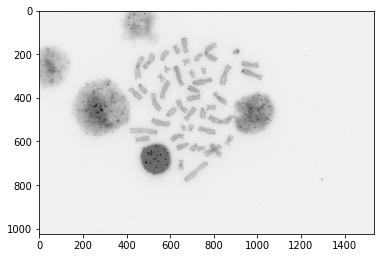

In [11]:
meta = 15
plt.figure(figsize=(6, 6))
dapi = metaphase_reshifted[meta][0]
telo = metaphase_reshifted[meta][1]
plt.imshow(dapi+telo, cmap= plt.cm.gray_r)

### Top Hat is performed on both dapi and cy3 components with structuring elements of variable size

In [12]:
kernel100 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(100,100))
kernel18 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
cross = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
#print cross

In [13]:
topHat = {}
for idx in metaphase_reshifted.keys():
    d,c = metaphase_reshifted[idx]
    dapi_cv = cv2.morphologyEx(d, cv2.MORPH_TOPHAT, kernel100)
    cy3_cv = cv2.morphologyEx(c, cv2.MORPH_TOPHAT, kernel18)
    topHat[idx] = dapi_cv,cy3_cv

### Perform segmentation on top hat filtered images

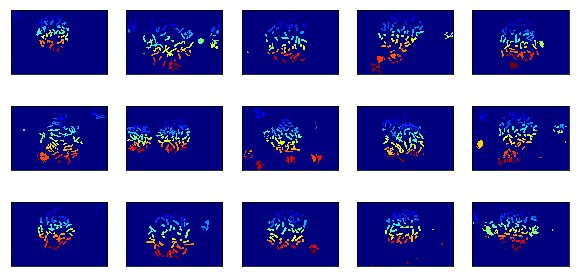

In [14]:
plt.figure(figsize=(10, 5))
for i in range(1,16):
    plt.subplot(3,5,i, xticks=[],yticks=[])
    plt.imshow(segmentDAPI(i, topHat), interpolation='nearest', cmap = plt.cm.jet)

some check

In [15]:
meta = 11
dapi = np.uint8(metaphase_reshifted[meta][0]/16.0)
telo = np.uint8(metaphase_reshifted[meta][1]/16.0)
label = segmentDAPI(meta, topHat)
print np.max(label)

44


extract the segmented 'particles'(chromosomes,piece of nuclei ...)  (interactive session)

In [16]:
chr_dapi = gt.ResizeImages(gt.extractParticles_2(dapi,label))
chr_cy3 = gt.ResizeImages(gt.extractParticles_2(telo,label))

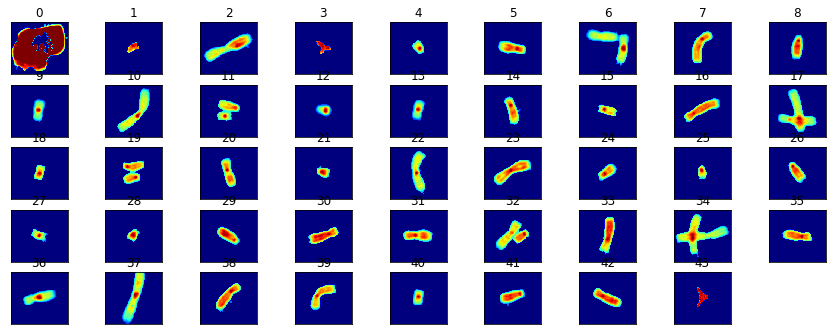

In [17]:
plt.figure(figsize=(15, 9))
for  i, krom in enumerate(chr_dapi):
    plt.subplot(8,9,i+1, xticks=[],yticks=[])
    plt.title(i)
    plt.imshow(krom, interpolation='nearest', cmap = plt.cm.jet)

## The overlapping chromosomes are identified:

   * The index of identified overlapping chromomes are saved in a dict (keys:metaphases)
   * then the chromosomes are extracted (dapi and cy3 spectral components)

In [18]:
# User selected overlapping / touching chromosomes
overlap_idx = {}
overlap_idx[1]=[1,4, 9, 11, 12, 13, 15, 16, 18, 19, 21,25, 26 ]
overlap_idx[2]=[0, 1, 18, 24, 30, 31, 32]
overlap_idx[4]=[12, 38, 43]
overlap_idx[5]=[1, 11, 36]
overlap_idx[6]=[0, 4, 5, 19,26, 34, 36, 47]
overlap_idx[7]=[2, 9, 12, 13, 15, 20, 22, 25, 28, 32, 35, 41, 42, 48, 50, 54]
overlap_idx[8]=[12, 18, 19, 25, 32, 38, 39, 42, 44, 45]
overlap_idx[9]=[7, 11, 19, 20, 24, 27, 29]
overlap_idx[10]=[4, 13, 24, 40,44, 49]
overlap_idx[11]=[6, 11, 17, 19, 32, 34]
overlap_idx[12]=[18, 22, 39]
overlap_idx[13]=[6, 8, 19, 25, 32, 36]
overlap_idx[14]=[2, 3, 5, 6, 10, 15, 18, 27, 34]
overlap_idx[15]=[27, 56, 57]

#not too smart, redoing seg ..
#overlappings_dapi = []
#overlappings_cy3 = []
overlappings = []
for meta in overlap_idx.keys():
    
    dapi = np.uint8(metaphase_reshifted[meta][0]/16.0)
    telo = np.uint8(metaphase_reshifted[meta][1]/16.0)
    label = segmentDAPI(meta, topHat)
    
    chr_dapi = gt.ResizeImages(gt.extractParticles_2(dapi,label))
    chr_cy3 = gt.ResizeImages(gt.extractParticles_2(telo,label))

    print meta, [idx for idx in overlap_idx[meta]]
    overlappings = overlappings + [(chr_dapi[idx], chr_cy3[idx]) for idx in overlap_idx[meta]]
    
    #for kroms_idx in overlap_idx:
    #    print 
    #    overlappings_dapi.update({meta:chr_dapi[kroms_idx]})
    #    overlappings_cy3.update({meta:chr_cy3[kroms_idx]})

1 [1, 4, 9, 11, 12, 13, 15, 16, 18, 19, 21, 25, 26]
2 [0, 1, 18, 24, 30, 31, 32]
4 [12, 38, 43]
5 [1, 11, 36]
6 [0, 4, 5, 19, 26, 34, 36, 47]
7 [2, 9, 12, 13, 15, 20, 22, 25, 28, 32, 35, 41, 42, 48, 50, 54]
8 [12, 18, 19, 25, 32, 38, 39, 42, 44, 45]
9 [7, 11, 19, 20, 24, 27, 29]
10 [4, 13, 24, 40, 44, 49]
11 [6, 11, 17, 19, 32, 34]
12 [18, 22, 39]
13 [6, 8, 19, 25, 32, 36]
14 [2, 3, 5, 6, 10, 15, 18, 27, 34]
15 [27, 56, 57]


rgb images are also generated

In [19]:
print len(overlappings)
resized_combinations = gt.ResizeImages([np.uint8(krom[0]/2.0+krom[1]/2.0) for krom in overlappings])

red = np.uint8(cy3_cv)
green = np.zeros(cy3_cv.shape, dtype=np.uint8)
blue = np.uint8(dapi_cv)

color = np.dstack((red, green, blue))

def color8(components):
    red = krom[1]
    green = np.zeros(krom[0].shape, dtype=np.uint8)
    blue = krom[0]
    return np.dstack((red,green, blue))

resized_color = gt.ResizeImages([color8(krom) for krom in overlappings])

100


### Let's have a look:

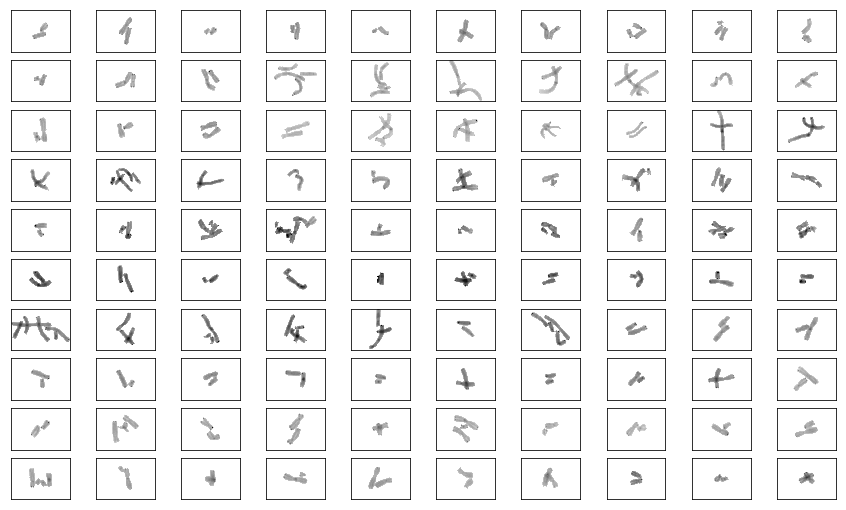

In [119]:
plt.figure(figsize=(15, 9))
for i, krom in enumerate(resized_combinations):
    plt.subplot(10,10,i+1, xticks=[],yticks=[])
    #plt.title(i)
    plt.imshow(krom, interpolation='nearest', cmap = plt.cm.gray_r, vmin=5, vmax=150)

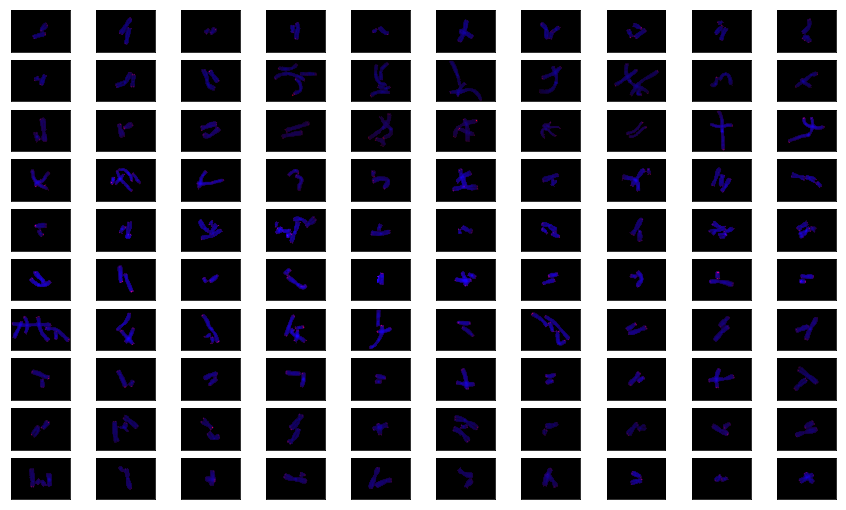

In [21]:
plt.figure(figsize=(15, 9))
for i, krom in enumerate(resized_color):
    plt.subplot(10,10,i+1, xticks=[],yticks=[])
    #plt.title(i)
    plt.imshow(krom, interpolation='nearest')

### Now save the image somewhere

In [23]:
n=1
for meta in overlap_idx.keys():
    for kridx in overlap_idx[meta]:
        name = '%02d' % meta
        name = 'meta'+name + '_'+str('%02d'% kridx)+'_'+str('%03d' % n)
        #print name
        image = resized_combinations[n-1]
        n=n+1
        #/home/jeanpat/DeepFISH-Github_projects/DeepFISH/Raw images/jpp21/100_Overlapping_Chromosomes
        imsave(os.path.join('..','Raw images','jpp21','100_Overlapping_Chromosomes','combined_DAPI_Cy3',name+'.png'), image)
        

In [25]:
n=1
for meta in overlap_idx.keys():
    for kridx in overlap_idx[meta]:
        name = '%02d' % meta
        name = 'color-meta'+name + '_'+str('%02d'% kridx)+'_'+str('%03d' % n)
        #print name
        image = resized_color[n-1]
        n=n+1
        #/home/jeanpat/DeepFISH-Github_projects/DeepFISH/Raw images/jpp21/100_Overlapping_Chromosomes
        imsave(os.path.join('..','Raw images','jpp21','100_Overlapping_Chromosomes','Color',name+'.png'), image)